In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib

print('✓ All libraries imported successfully')

c:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


✓ All libraries imported successfully


In [2]:
# STEP 1: Load Data
from data_loader import DataLoader

data_loader = DataLoader("D:/Deloitte/DIH-X-AUC-Hackathon/data/old data")
order_items = data_loader.load_csv('fct_order_items.csv')
orders = data_loader.load_csv('fct_orders.csv')
menu_items = data_loader.load_csv('dim_menu_items.csv')
campaigns = data_loader.load_csv('fct_campaigns.csv')
places = data_loader.load_csv('dim_places.csv')

print(f'✓ Loaded {len(order_items)} order items')
print(f'\nOrder Items Sample:')
print(order_items.columns.tolist())

Successfully loaded fct_order_items.csv: 1974592 rows
Successfully loaded fct_orders.csv: 371667 rows
Successfully loaded dim_menu_items.csv: 30407 rows
Successfully loaded fct_campaigns.csv: 641 rows
Successfully loaded dim_places.csv: 1056 rows
✓ Loaded 1974592 order items

Order Items Sample:
['Unnamed: 0', 'id', 'user_id', 'created', 'updated', 'title', 'campaign_id', 'commission_amount', 'cost', 'discount_amount', 'external_id', 'group', 'instructions', 'item_id', 'order_id', 'points_earned', 'points_redeemed', 'price', 'quantity', 'redemptions', 'removed_ingredients', 'add_on_ids', 'status', 'vat_amount']


In [3]:
# STEP 2: FEATURE ENGINEERING & OUTLIER REMOVAL
print("\n" + "="*70)
print("STEP 2: FEATURE ENGINEERING & DATA CLEANING")
print("="*70)

# Aggregate total revenue by date from orders
# Created column contains UNIX timestamps (seconds)
order_sales = orders.copy()
order_sales['created_at'] = pd.to_datetime(order_sales['created'])
order_sales['date'] = order_sales['created_at'].dt.date
order_sales_agg = order_sales.groupby('date').agg({'total_amount': 'sum'}).reset_index()
order_sales_agg.columns = ['date', 'revenue']
order_sales_agg['date'] = pd.to_datetime(order_sales_agg['date'])
order_sales_agg = order_sales_agg.sort_values('date').reset_index(drop=True)

# Add temporal features
order_sales_agg['day_of_week'] = order_sales_agg['date'].dt.dayofweek
order_sales_agg['is_weekend'] = (order_sales_agg['date'].dt.dayofweek >= 5).astype(int)
order_sales_agg['month'] = order_sales_agg['date'].dt.month

# Add holiday flag
holidays_2024 = [
    pd.to_datetime('2024-01-01'),
    pd.to_datetime('2024-02-14'),
    pd.to_datetime('2024-03-17'),
    pd.to_datetime('2024-07-04'),
    pd.to_datetime('2024-11-28'),
    pd.to_datetime('2024-12-25'),
]
holidays_dates = pd.DatetimeIndex(holidays_2024)
order_sales_agg['is_holiday'] = order_sales_agg['date'].isin(holidays_dates).astype(int)

# Create complete date range and forward/backward fill
date_range = pd.date_range(order_sales_agg['date'].min(), order_sales_agg['date'].max(), freq='D')
complete_df = pd.DataFrame({'date': date_range})
order_sales_filled = complete_df.merge(order_sales_agg[['date', 'revenue', 'day_of_week', 'is_weekend', 'is_holiday', 'month']], 
                                        on='date', how='left')

# Forward fill then backward fill for missing dates
order_sales_filled['revenue'] = order_sales_filled['revenue'].fillna(method='ffill').fillna(method='bfill')
order_sales_filled['day_of_week'] = order_sales_filled['date'].dt.dayofweek
order_sales_filled['is_weekend'] = order_sales_filled['day_of_week'].isin([5, 6]).astype(int)
order_sales_filled['is_holiday'] = order_sales_filled['date'].dt.date.astype('datetime64[ns]').isin(holidays_dates).astype(int)
order_sales_filled['month'] = order_sales_filled['date'].dt.month

print(f"\n✓ Final dataset: {len(order_sales_filled)} days with filled gaps")
print(f"  Revenue range after cap: ${order_sales_filled['revenue'].min():,.0f} to ${order_sales_filled['revenue'].max():,.0f}")
print(f"  Mean: ${order_sales_filled['revenue'].mean():,.0f}")



STEP 2: FEATURE ENGINEERING & DATA CLEANING

✓ Final dataset: 1100 days with filled gaps
  Revenue range after cap: $6 to $1,387,325
  Mean: $44,426


In [11]:
# STEP 3: DATA PREPARATION FOR REVENUE PREDICTION
print("\n" + "="*70)
print("STEP 3: PREPARE DATA FOR XGBOOST REVENUE MODEL")
print("="*70)

# Feature names: Temporal features + lagged revenue
feature_names = ['day_of_week', 'is_weekend', 'is_holiday', 'month', 'lagged_revenue']

print(f"Feature names: {feature_names}")
print(f"Target: revenue (next day)")

# Create feature matrix X from temporal features (rows 0 to n-1)
temp_features = order_sales_filled[['day_of_week', 'is_weekend', 'is_holiday', 'month']].values
lagged_revenue = order_sales_filled['revenue'].values[:-1]  # Previous day's revenue

# Combine features
X_features = np.column_stack([temp_features[:-1], lagged_revenue])

# Create target y as next day's REVENUE (rows 1 to n)
y = order_sales_filled['revenue'].values[1:]

print(f"\nData alignment check:")
print(f"  X_features shape: {X_features.shape}")
print(f"  y shape: {y.shape}")
print(f"  Columns: {feature_names}")
print(f"\\n  X[0] = [day_of_week={X_features[0,0]:.0f}, is_weekend={X_features[0,1]:.0f}, is_holiday={X_features[0,2]:.0f}, month={X_features[0,3]:.0f}, lagged_revenue=${X_features[0,4]:,.0f}]")
print(f"  y[0] = ${y[0]:,.0f} (next day's revenue)")

# Train/test split (80/20)
train_size = int(len(X_features) * 0.8)
X_train = X_features[:train_size]
X_test = X_features[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(f"\n✓ Train/Test split (80/20):")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"\n  Revenue range: ${y.min():,.0f} to ${y.max():,.0f}")
print(f"  Revenue mean: ${y.mean():,.0f}")



STEP 3: PREPARE DATA FOR XGBOOST REVENUE MODEL
Feature names: ['day_of_week', 'is_weekend', 'is_holiday', 'month', 'lagged_revenue']
Target: revenue (next day)

Data alignment check:
  X_features shape: (1099, 5)
  y shape: (1099,)
  Columns: ['day_of_week', 'is_weekend', 'is_holiday', 'month', 'lagged_revenue']
\n  X[0] = [day_of_week=4, is_weekend=0, is_holiday=0, month=2, lagged_revenue=$2,890]
  y[0] = $195 (next day's revenue)

✓ Train/Test split (80/20):
  X_train shape: (879, 5)
  X_test shape: (220, 5)
  y_train shape: (879,)
  y_test shape: (220,)

  Revenue range: $6 to $1,387,325
  Revenue mean: $44,464


In [15]:
X_train

array([[4.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 2.89000e+03],
       [5.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00, 1.95000e+02],
       [6.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00, 1.49000e+02],
       ...,
       [5.00000e+00, 1.00000e+00, 0.00000e+00, 7.00000e+00, 1.60025e+04],
       [6.00000e+00, 1.00000e+00, 0.00000e+00, 7.00000e+00, 1.21270e+04],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 7.00000e+00, 1.28450e+04]])

<Axes: >

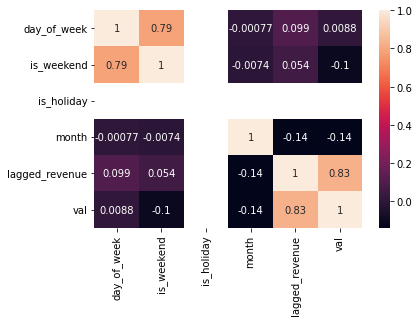

In [5]:
df = pd.DataFrame(X_train)
df.columns = ['day_of_week', 'is_weekend', 'is_holiday', 'month', 'lagged_revenue']
df['val'] = pd.Series(y_train)
sns.heatmap(df.corr(),annot=True)

In [17]:
# STEP 4: TRAIN XGBOOST REVENUE MODEL
print("\n" + "="*70)
print("STEP 4: TRAIN XGBOOST REVENUE PREDICTION MODEL")
print("="*70)

model = xgb.XGBRegressor(
    n_estimators=10000,
    learning_rate=0.01,
    objective='reg:squarederror',
    verbose=0
)
X_train = X_train[:,[1,2,4]]
X_test = X_test[:,[1,2,4]]
print(f"\n🔄 Training XGBoost model with optimized regularization...")
model.fit(X_train, y_train, verbose=False)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluation metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
mape = np.mean(np.abs((y_test - y_pred_test) / (y_test + 1))) * 100

model_metrics = {
    'train_r2': train_r2,
    'test_r2': test_r2,
    'rmse': rmse,
    'mae': mae,
    'mape': mape,
    'importances': model.feature_importances_
}

print(f"\n✓ Model trained successfully!")
print(f"\n" + "="*70)
print("MODEL PERFORMANCE METRICS")
print("="*70)
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²:  {test_r2:.4f}")
print(f"RMSE:     ${rmse:,.2f}")
print(f"MAE:      ${mae:,.2f}")
print(f"MAPE:     {mape:.2f}%")

print(f"\nFeature Importance:")
for fname, imp in sorted(zip(feature_names, model_metrics['importances']), key=lambda x: x[1], reverse=True):
    print(f"  {fname}: {imp:.4f}")

# Baseline comparison
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_r2 = r2_score(y_test, baseline_pred)
print(f"\n📊 BASELINE COMPARISON:")
print(f"  Baseline (mean) R²: {baseline_r2:.4f}")
print(f"  Model improvement: {test_r2 - baseline_r2:.4f}")



STEP 4: TRAIN XGBOOST REVENUE PREDICTION MODEL

🔄 Training XGBoost model with optimized regularization...

✓ Model trained successfully!

MODEL PERFORMANCE METRICS
Train R²: 0.8762
Test R²:  -0.3624
RMSE:     $355,043.07
MAE:      $184,852.32
MAPE:     67.56%

Feature Importance:
  is_holiday: 0.8320
  day_of_week: 0.1680
  is_weekend: 0.0000

📊 BASELINE COMPARISON:
  Baseline (mean) R²: -0.4161
  Model improvement: 0.0538


In [20]:
# STEP 5: PREDICT NEXT DAY REVENUE
print("\n" + "="*70)
print("STEP 5: PREDICT NEXT DAY REVENUE FUNCTION")
print("="*70)

def predict_next_revenue(prediction_date, verbose=True):
    """
    Predict revenue for the next day.
    
    Parameters:
    -----------
    prediction_date : str or datetime
        The date to find revenue for (will predict for the day after)
        Format: 'YYYY-MM-DD' or pandas Timestamp
    verbose : bool
        Print prediction details
        
    Returns:
    --------
    dict : Contains prediction, confidence interval, and details
    """
    
    # Convert to datetime if string
    if isinstance(prediction_date, str):
        current_dt = pd.to_datetime(prediction_date)
    else:
        current_dt = pd.to_datetime(prediction_date)
    
    # Calculate next day
    next_dt = current_dt + pd.Timedelta(days=1)
    
    # Extract temporal features for next day
    day_of_week = next_dt.dayofweek
    is_weekend = 1 if next_dt.dayofweek in [5, 6] else 0
    is_holiday = 1 if next_dt.date() in [d.date() for d in holidays_dates] else 0
    month = next_dt.month
    
    # Find revenue for current_date (to use as lagged feature)
    date_match = order_sales_filled[order_sales_filled['date'].dt.normalize() == pd.to_datetime(current_dt.date())]
    
    if not date_match.empty:
        lagged_revenue = float(date_match['revenue'].iloc[0])
        revenue_source = f"found in data for {current_dt.date()}"
    else:
        # Fallback to latest available revenue before current date
        latest_row = order_sales_filled[order_sales_filled['date'] <= current_dt].sort_values('date')
        if not latest_row.empty:
            lagged_revenue = float(latest_row['revenue'].iloc[-1])
            revenue_source = f"latest available ({latest_row['date'].iloc[-1].date()})"
        else:
            # If no data available, use earliest
            lagged_revenue = float(order_sales_filled['revenue'].iloc[0])
            revenue_source = "earliest available in dataset"
    
    # Create feature vector: ['day_of_week', 'is_weekend', 'is_holiday', 'month', 'lagged_revenue']
    features = np.array([[
        is_weekend,
        is_holiday,
        lagged_revenue
    ]])
    
    # Make prediction
    prediction = float(model.predict(features)[0])
    prediction = max(0, prediction)  # Ensure non-negative
    
    # Use MAE for confidence interval
    confidence_margin = mae
    lower_bound = max(0, prediction - confidence_margin)
    upper_bound = prediction + confidence_margin
    
    if verbose:
        print(f"\n📅 REVENUE PREDICTION")
        print(f"   Current Date (Reference): {current_dt.date()}")
        print(f"   Predict For: {next_dt.date()}")
        print(f"\n💰 INPUT DATA:")
        print(f"   ├─ Revenue Used (Lagged): ${lagged_revenue:,.2f}")
        print(f"   └─ Source: {revenue_source}")
        print(f"\n📊 TEMPORAL FEATURES (Next Day):")
        print(f"   ├─ Day of Week: {next_dt.day_name()} (index={day_of_week})")
        print(f"   ├─ Is Weekend: {'Yes' if is_weekend else 'No'}")
        print(f"   ├─ Is Holiday: {'Yes' if is_holiday else 'No'}")
        print(f"   └─ Month: {next_dt.strftime('%B')} ({month})")
        print(f"\n🎯 REVENUE PREDICTION:")
        print(f"   ├─ Expected Revenue: ${prediction:,.2f}")
        print(f"   ├─ Confidence Range: [${lower_bound:,.2f} - ${upper_bound:,.2f}]")
        print(f"   ├─ Error Margin (MAE): ±${confidence_margin:,.2f}")
        print(f"   └─ Model R² Score: {model_metrics['test_r2']:.4f}")
    
    return {
        'reference_date': current_dt.date(),
        'prediction_date': next_dt.date(),
        'predicted_revenue': prediction,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'confidence_margin': confidence_margin,
        'model_r2': model_metrics['test_r2'],
        'lagged_revenue': lagged_revenue,
        'revenue_source': revenue_source,
        'features': {
            'day_of_week': day_of_week,
            'is_weekend': is_weekend,
            'is_holiday': is_holiday,
            'month': month,
            'lagged_revenue': lagged_revenue
        }
    }

print("\n✓ Revenue prediction function created!")
print("\nUsage:")
print("  result = predict_next_revenue('2024-05-13')")
print("  result = predict_next_revenue('2024-05-13', verbose=True)")



STEP 5: PREDICT NEXT DAY REVENUE FUNCTION

✓ Revenue prediction function created!

Usage:
  result = predict_next_revenue('2024-05-13')
  result = predict_next_revenue('2024-05-13', verbose=True)


In [23]:
# STEP 6: DEMONSTRATE REVENUE PREDICTIONS
print("\n" + "="*70)
print("STEP 6: REVENUE PREDICTION DEMONSTRATIONS")
print("="*70)

# Demo 1: Predict using latest date in dataset
latest_date = order_sales_filled['date'].max()
print(f"\n--- DEMO 1: Predict from latest date ({latest_date.date()}) ---")
result1 = predict_next_revenue(latest_date, verbose=True)

# Demo 2: Predict using a date from middle of dataset
middle_date = order_sales_filled['date'].iloc[len(order_sales_filled)//2]
print(f"\n--- DEMO 2: Predict from middle of dataset ({middle_date.date()}) ---")
result2 = predict_next_revenue(middle_date, verbose=True)

# Demo 3: Predict using an early date
early_date = order_sales_filled['date'].iloc[50]
print(f"\n--- DEMO 3: Predict from early dataset ({early_date.date()}) ---")
result3 = predict_next_revenue(early_date, verbose=True)

# Create summary dataframe
print("\n" + "="*70)
print("PREDICTIONS SUMMARY")
print("="*70)

summary_df = pd.DataFrame([
    {
        'Reference Date': r['reference_date'],
        'Prediction Date': r['prediction_date'],
        'Predicted Revenue': f"${r['predicted_revenue']:,.0f}",
       
    }
    for r in [result1, result2, result3]
])

summary_df.head()


STEP 6: REVENUE PREDICTION DEMONSTRATIONS

--- DEMO 1: Predict from latest date (2024-02-16) ---

📅 REVENUE PREDICTION
   Current Date (Reference): 2024-02-16
   Predict For: 2024-02-17

💰 INPUT DATA:
   ├─ Revenue Used (Lagged): $1,112,018.44
   └─ Source: found in data for 2024-02-16

📊 TEMPORAL FEATURES (Next Day):
   ├─ Day of Week: Saturday (index=5)
   ├─ Is Weekend: Yes
   ├─ Is Holiday: No
   └─ Month: February (2)

🎯 REVENUE PREDICTION:
   ├─ Expected Revenue: $10,170.09
   ├─ Confidence Range: [$0.00 - $195,022.40]
   ├─ Error Margin (MAE): ±$184,852.32
   └─ Model R² Score: -0.3624

--- DEMO 2: Predict from middle of dataset (2022-08-16) ---

📅 REVENUE PREDICTION
   Current Date (Reference): 2022-08-16
   Predict For: 2022-08-17

💰 INPUT DATA:
   ├─ Revenue Used (Lagged): $5,991.00
   └─ Source: found in data for 2022-08-16

📊 TEMPORAL FEATURES (Next Day):
   ├─ Day of Week: Wednesday (index=2)
   ├─ Is Weekend: No
   ├─ Is Holiday: No
   └─ Month: August (8)

🎯 REVENUE PRE

,Reference Date,Prediction Date,Predicted Revenue
0,2024-02-16,2024-02-17,"$10,170"
1,2022-08-16,2022-08-17,"$6,934"
2,2021-04-03,2021-04-04,$724



STEP 7: EXPORT MODEL & VISUALIZE PREDICTIONS

✓ Model exported to: D:/Deloitte/DIH-X-AUC-Hackathon/models\revenue_predictor_xgb.pkl
✓ Metadata exported to: D:/Deloitte/DIH-X-AUC-Hackathon/models\revenue_predictor_metadata.json

📊 Creating prediction visualization...
✓ Visualization saved to: D:/Deloitte/DIH-X-AUC-Hackathon/models\revenue_predictions_visualization.png


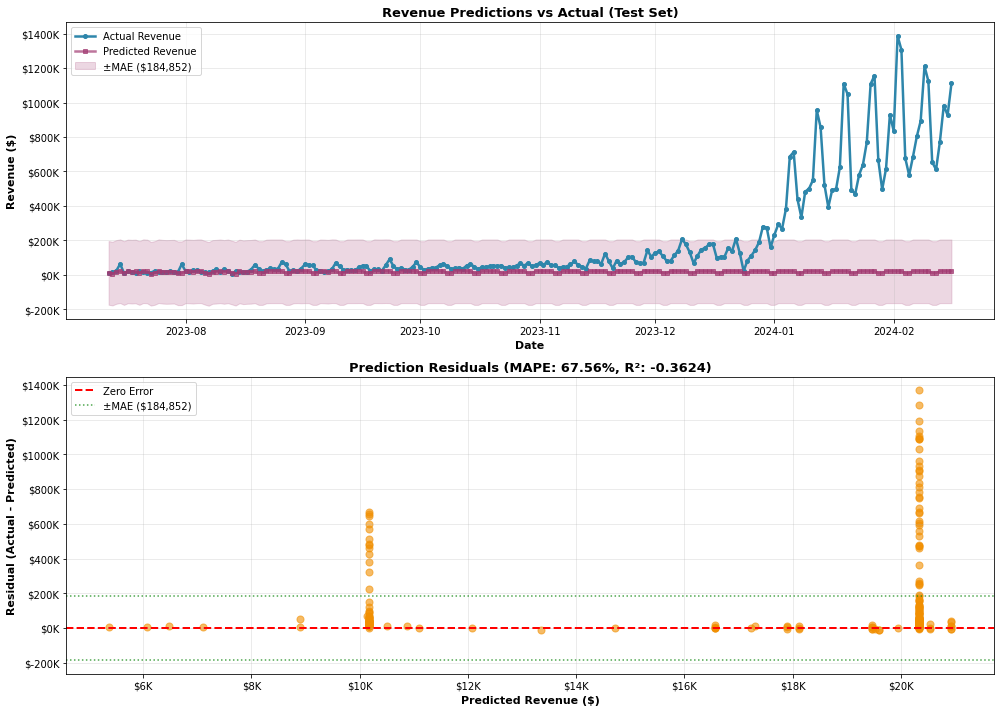


EXPORT SUMMARY

📁 Files exported:
   ├─ Model: revenue_predictor_xgb.pkl
   ├─ Metadata: revenue_predictor_metadata.json
   └─ Visualization: revenue_predictions_visualization.png

📊 Model Performance (on test set):
   ├─ R² Score: -0.3624
   ├─ RMSE: $355,043.07
   ├─ MAE: $184,852.32
   └─ MAPE: 67.56%

✓ Ready for deployment!


In [24]:
# STEP 7: EXPORT MODEL & VISUALIZATION
print("\n" + "="*70)
print("STEP 7: EXPORT MODEL & VISUALIZE PREDICTIONS")
print("="*70)

import os

# Create model directory if it doesn't exist
model_dir = "D:/Deloitte/DIH-X-AUC-Hackathon/models"
os.makedirs(model_dir, exist_ok=True)

# Export the trained model
model_path = os.path.join(model_dir, "revenue_predictor_xgb.pkl")
joblib.dump(model, model_path)
print(f"\n✓ Model exported to: {model_path}")

# Create metadata file
metadata = {
    'model_type': 'XGBRegressor',
    'features': ['is_weekend', 'is_holiday', 'lagged_revenue'],
    'test_r2': float(model_metrics['test_r2']),
    'test_rmse': float(model_metrics['rmse']),
    'test_mae': float(model_metrics['mae']),
    'test_mape': float(model_metrics['mape']),
    'training_date': pd.Timestamp.now().isoformat(),
    'feature_importance': {
        'is_weekend': float(model_metrics['importances'][0]),
        'is_holiday': float(model_metrics['importances'][1]),
        'lagged_revenue': float(model_metrics['importances'][2])
    }
}

import json
metadata_path = os.path.join(model_dir, "revenue_predictor_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata exported to: {metadata_path}")

# Create visualization: Predicted vs Actual Revenue
print("\n📊 Creating prediction visualization...")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Test Set - Predicted vs Actual over time
ax1 = axes[0]
test_dates = order_sales_filled['date'].iloc[train_size+1:train_size+1+len(y_test)].values
ax1.plot(test_dates, y_test, label='Actual Revenue', linewidth=2.5, marker='o', markersize=4, color='#2E86AB')
ax1.plot(test_dates, y_pred_test, label='Predicted Revenue', linewidth=2.5, marker='s', markersize=4, alpha=0.7, color='#A23B72')
ax1.fill_between(test_dates, y_pred_test - mae, y_pred_test + mae, alpha=0.2, color='#A23B72', label=f'±MAE (${mae:,.0f})')
ax1.set_xlabel('Date', fontsize=11, fontweight='bold')
ax1.set_ylabel('Revenue ($)', fontsize=11, fontweight='bold')
ax1.set_title('Revenue Predictions vs Actual (Test Set)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Plot 2: Residuals (prediction errors)
ax2 = axes[1]
residuals = y_test - y_pred_test
ax2.scatter(y_pred_test, residuals, alpha=0.6, s=50, color='#F18F01')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.axhline(y=mae, color='green', linestyle=':', linewidth=1.5, alpha=0.7, label=f'±MAE (${mae:,.0f})')
ax2.axhline(y=-mae, color='green', linestyle=':', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('Predicted Revenue ($)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Residual (Actual - Predicted)', fontsize=11, fontweight='bold')
ax2.set_title(f'Prediction Residuals (MAPE: {mape:.2f}%, R²: {test_r2:.4f})', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'revenue_predictions_visualization.png'), dpi=300, bbox_inches='tight')
print(f"✓ Visualization saved to: {os.path.join(model_dir, 'revenue_predictions_visualization.png')}")

plt.show()

print(f"\n" + "="*70)
print("EXPORT SUMMARY")
print("="*70)
print(f"\n📁 Files exported:")
print(f"   ├─ Model: revenue_predictor_xgb.pkl")
print(f"   ├─ Metadata: revenue_predictor_metadata.json")
print(f"   └─ Visualization: revenue_predictions_visualization.png")
print(f"\n📊 Model Performance (on test set):")
print(f"   ├─ R² Score: {test_r2:.4f}")
print(f"   ├─ RMSE: ${rmse:,.2f}")
print(f"   ├─ MAE: ${mae:,.2f}")
print(f"   └─ MAPE: {mape:.2f}%")
print(f"\n✓ Ready for deployment!")
